# Определение стоимости автомобилей

**Описание проекта:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Постройте модель, которая умеет её определять. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Условия выполнения проекта:**

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

**Основные шаги:**

- Загрузим данные, путь к файлу: /datasets/autos.csv.
- Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.
- Подготовим выборки для обучения моделей.
- Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
- Проанализируем время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

**Примечания:**
- Для оценки качества моделей примените метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del: del features_train 

**Описание данных:**

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**

- Price — цена (евро)

## Подготовка данных

In [1]:
! pip install -q phik

In [2]:
! pip install -q skimpy

In [3]:
! pip install -q -U matplotlib 

In [4]:
! pip install -q -U scikit-learn

In [5]:
! pip install -q -U catboost

In [6]:
# Импортируем необходимые модули
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik
import lightgbm as lgb
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from warnings import simplefilter
from catboost import Pool, CatBoostRegressor, cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from skimpy import clean_columns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

In [7]:
# Снимем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# Снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# Игнорируем предупреждения
pd.set_option('chained_assignment', None)

# Игнорировать все предупреждения
simplefilter(action='ignore', category=FutureWarning)

In [8]:
# Загрузим данные
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [9]:
print(data.shape)

(354369, 16)


In [10]:
print(data.head(3))
print()
print('Информация датасета:')
print(data.info())
print()
print('Описание датасета:')
print(data.describe())
print()
print(f'Количествово пропусков:{data.isna().sum()}') 
print()
print(f'Количествово дубликатов:{data.duplicated().sum()}')
print()
print('Уникальные значения датасета:')
print(data.nunique())

           DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  

Информация датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 

In [11]:
data[data.duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [12]:
data = data.drop_duplicates(keep='first')

In [13]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCrawled'] = pd.DatetimeIndex(data['DateCrawled']).year
data['DateCrawled'].unique()

array([2016], dtype=int32)

Так как выгрузка из базы была в 2016 году, то это и будет нашим ограничением по заданию года нашей выборки.

In [14]:
#Удалим ненужные для обучения столбцы
data = data.drop(columns=['LastSeen', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode'])
print(data)

        Price  VehicleType  RegistrationYear Gearbox  Power        Model  \
0         480          NaN              1993  manual      0         golf   
1       18300        coupe              2011  manual    190          NaN   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
...       ...          ...               ...     ...    ...          ...   
354364      0          NaN              2005  manual      0         colt   
354365   2200          NaN              2005     NaN      0          NaN   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        Kilometer  FuelType           Brand Repaired  
0          150000    petrol     

Существуют разные коэффициенты корреляции, и не все из них универсальны. Например, корреляция Пирсона не подходит для категориальных признаков. Есть и более гибкие инструменты: так, коэффициент корреляции Фи находит взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь. Используем этот передовой метод определения корреляции. Используя phik_matrix лучше вручную указать столбцы с количественными признаками через interval_cols, а то он иногда путается.

In [15]:
data.phik_matrix(interval_cols=['Price', 'RegistrationYear', 'Power', 'Kilometer'])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.268158,0.016817,0.323648,0.005752,0.579011,0.307896,0.257371,0.355425,0.380396
VehicleType,0.268158,1.000000,NaN,0.289225,0.011765,0.917247,0.173850,0.330153,0.633334,0.084349
RegistrationYear,0.016817,NaN,1.000000,0.003468,0.088713,0.087433,0.107644,0.040134,0.057000,0.011465
Gearbox,0.323648,0.289225,0.003468,1.000000,0.010497,0.647229,0.017876,0.151419,0.520804,0.043691
Power,0.005752,0.011765,0.088713,0.010497,1.000000,0.000000,0.008441,0.010882,0.004459,0.011678
Model,0.579011,0.917247,0.087433,0.647229,0.000000,1.000000,0.440728,0.554909,0.998376,0.159147
Kilometer,0.307896,0.173850,0.107644,0.017876,0.008441,0.440728,1.000000,0.149006,0.290936,0.113693
FuelType,0.257371,0.330153,0.040134,0.151419,0.010882,0.554909,0.149006,1.000000,0.322332,0.044509
Brand,0.355425,0.633334,0.057000,0.520804,0.004459,0.998376,0.290936,0.322332,1.000000,0.105522
Repaired,0.380396,0.084349,0.011465,0.043691,0.011678,0.159147,0.113693,0.044509,0.105522,1.000000


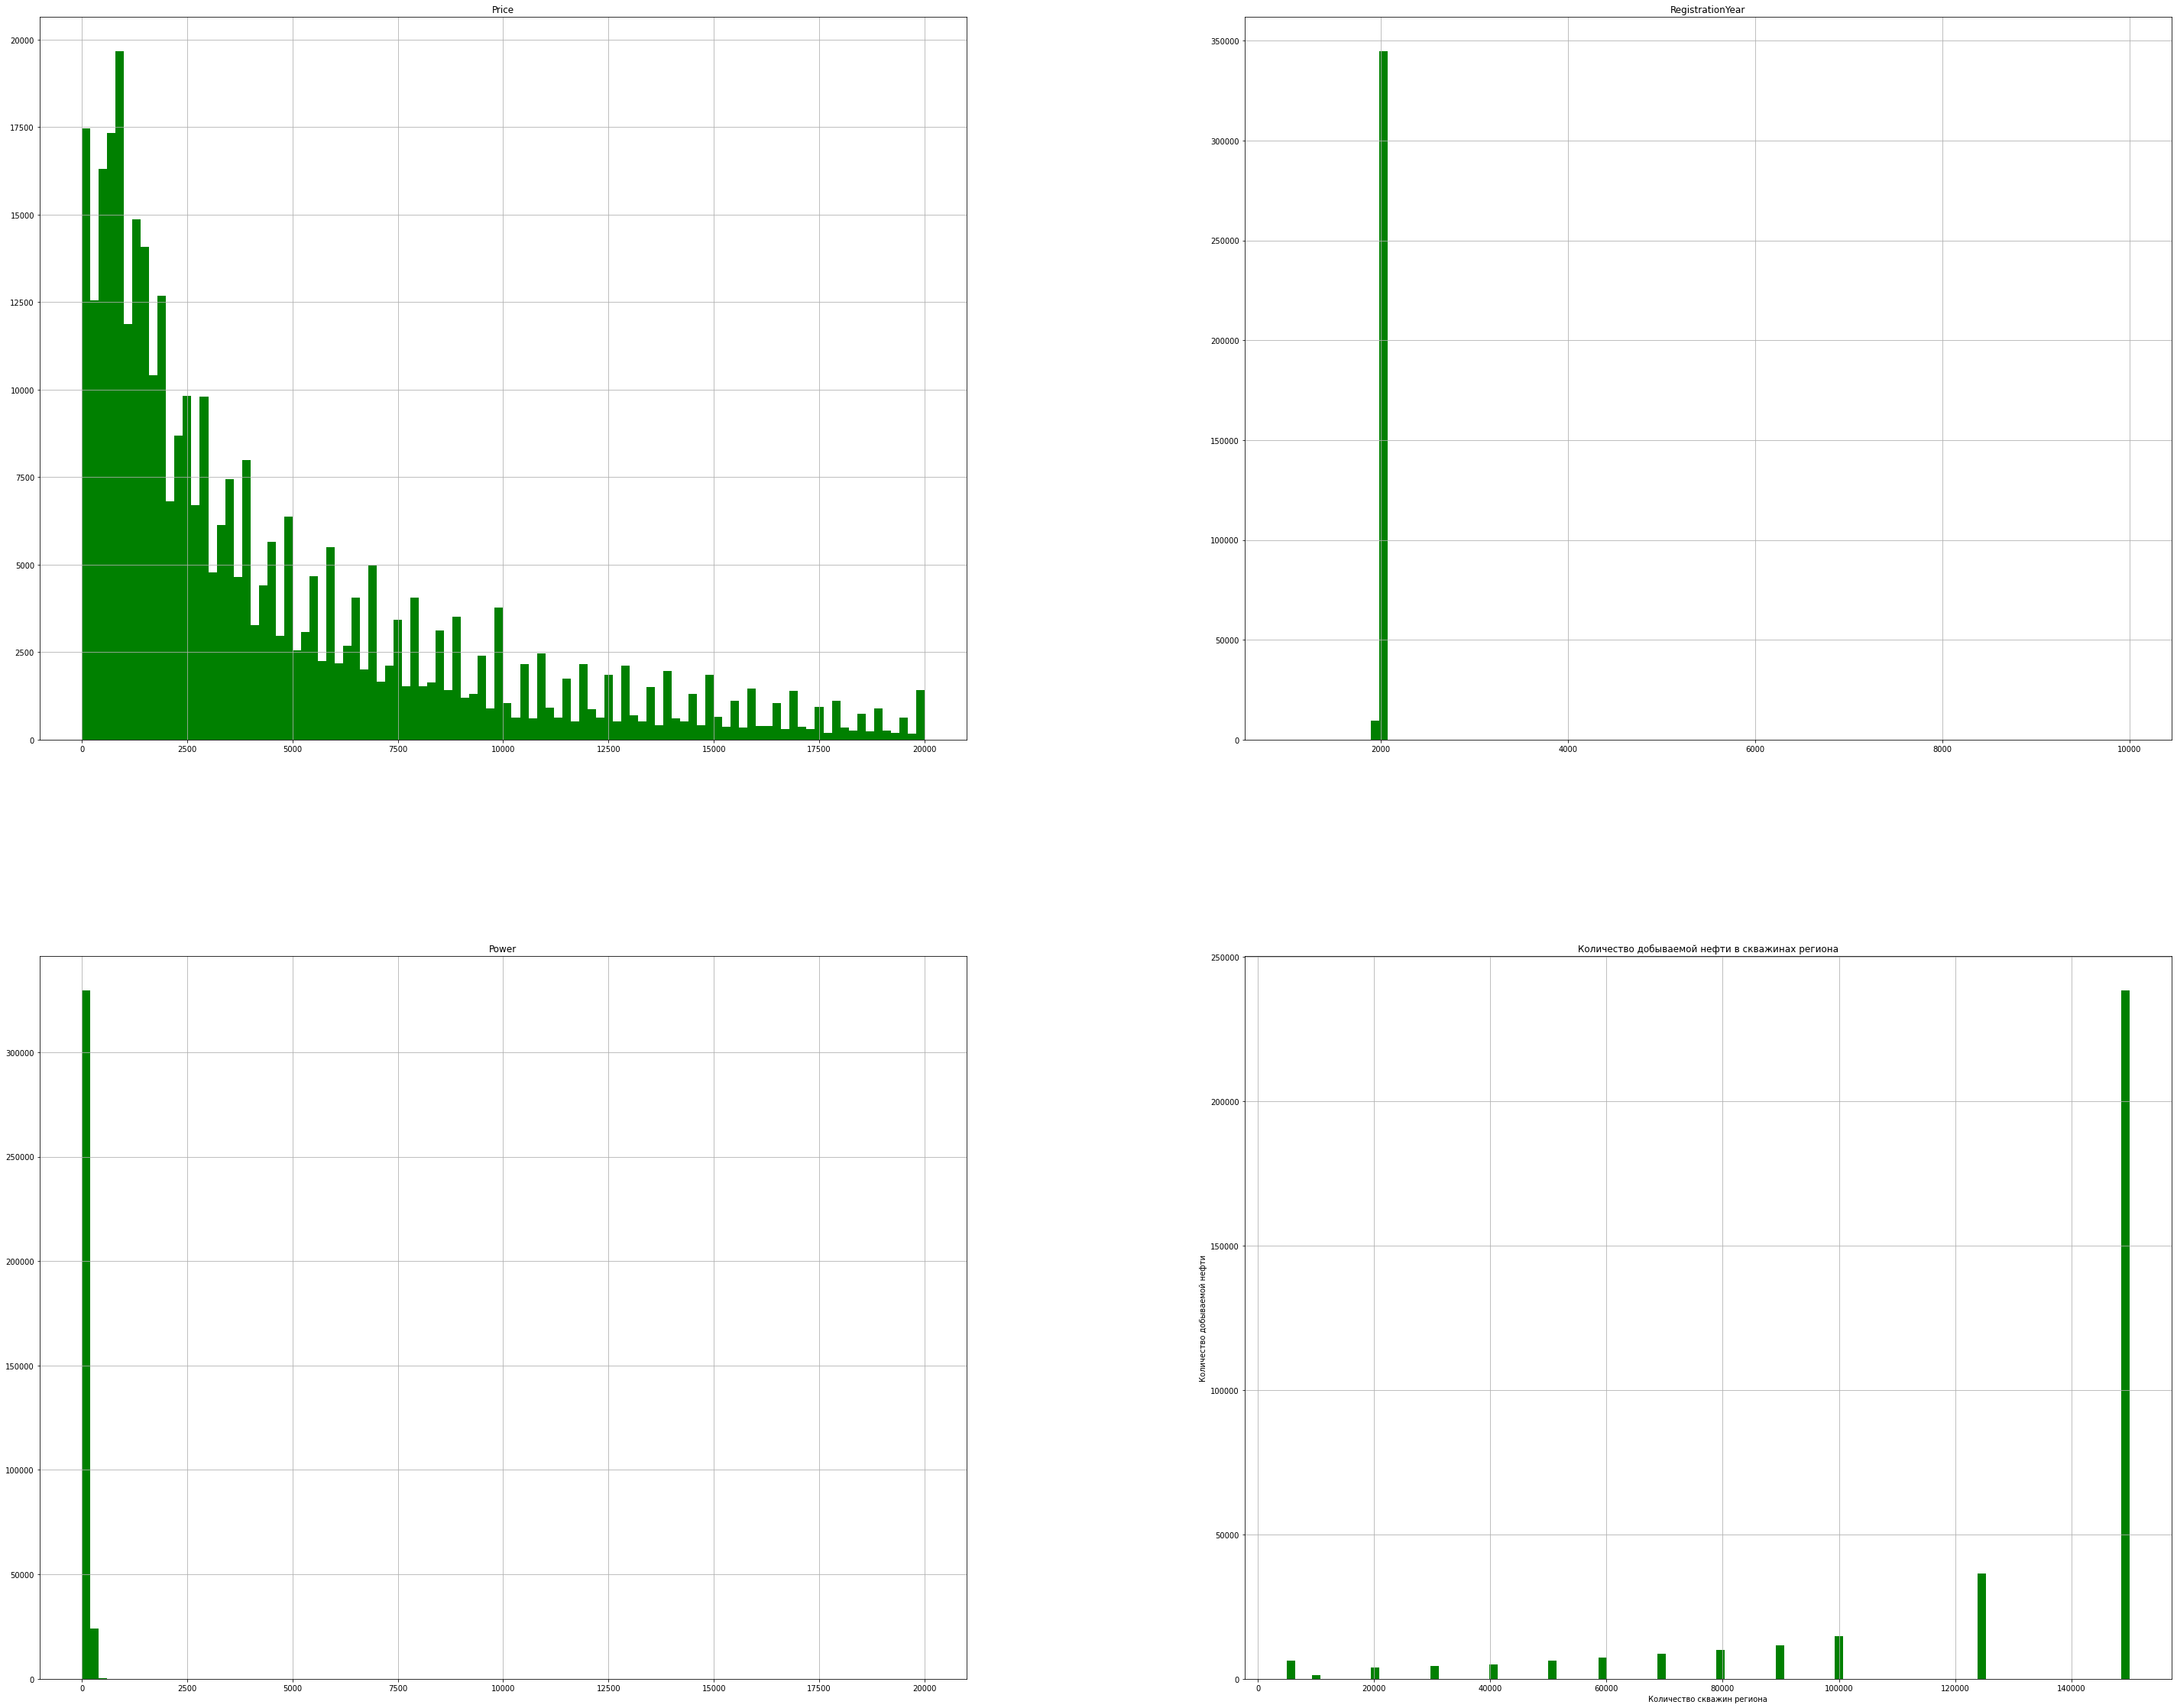

In [16]:
data.hist(figsize=(50, 40), bins=100, color='green')
plt.title('Количество добываемой нефти в скважинах региона')
plt.xlabel('Количество скважин региона')
plt.ylabel('Количество добываемой нефти')
plt.show();

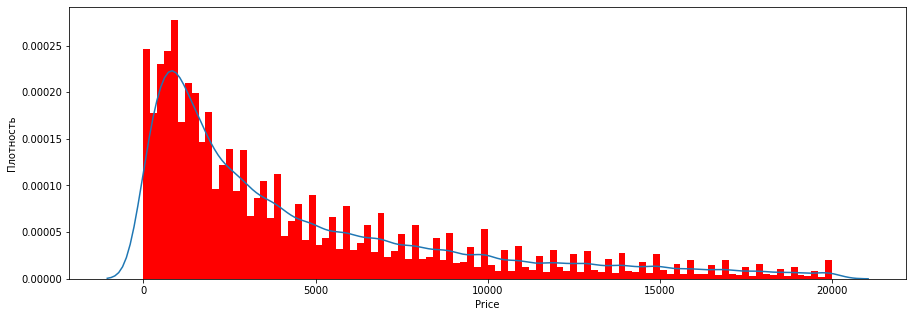

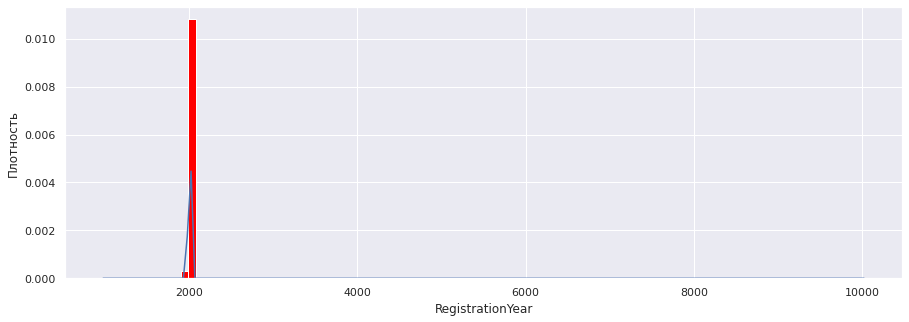

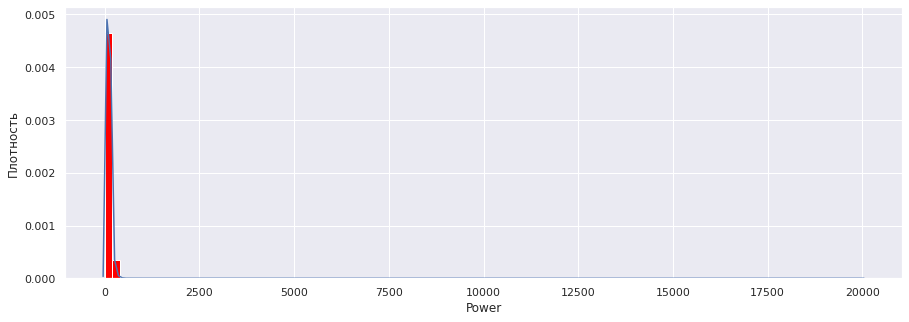

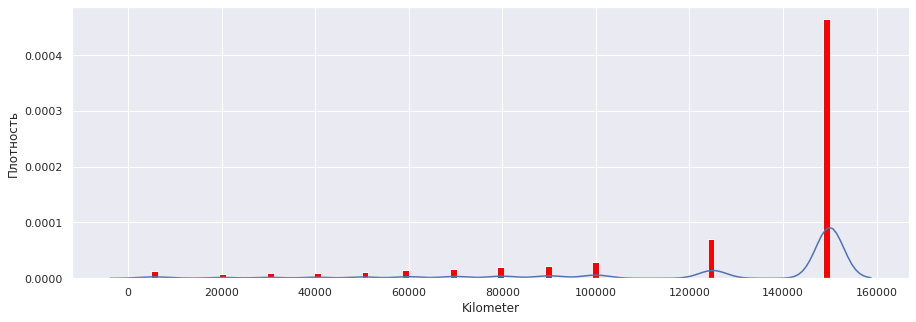

In [17]:
# Для сравнения распределений выборок с разным размером используем kde
columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
for col in columns:
    plt.rcParams['figure.figsize'] = (15, 5)
    ax = sns.distplot(a=data[col], label=data[col], hist=True, kde=True, rug=False, 
                      bins=100, hist_kws={"color":"red", "alpha":1})
    ax.set_ylabel('Плотность')
    sns.set(rc={'figure.figsize':(20,5)})
    plt.show();

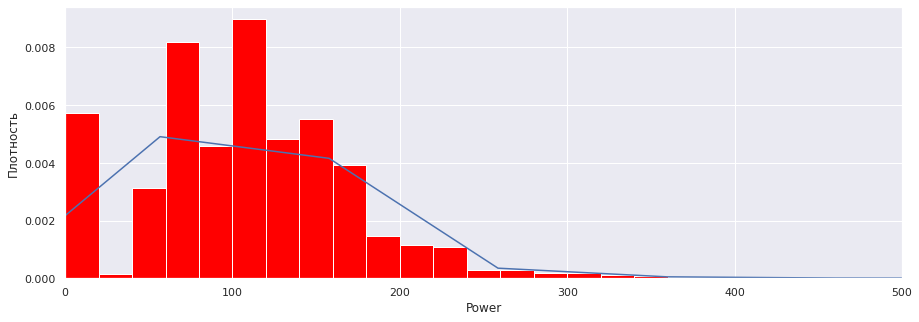

In [18]:
# Более детально посмотрим на столбец Power
plt.rcParams['figure.figsize'] = (15, 5)
ax = sns.distplot(a=data['Power'], label=data['Power'], hist=True, kde=True, rug=False, 
                  bins=1000, hist_kws={"color":"red", "alpha":1})
plt.xlim(0, 500)
ax.set_ylabel('Плотность')
sns.set(rc={'figure.figsize':(20,5)})
plt.show();

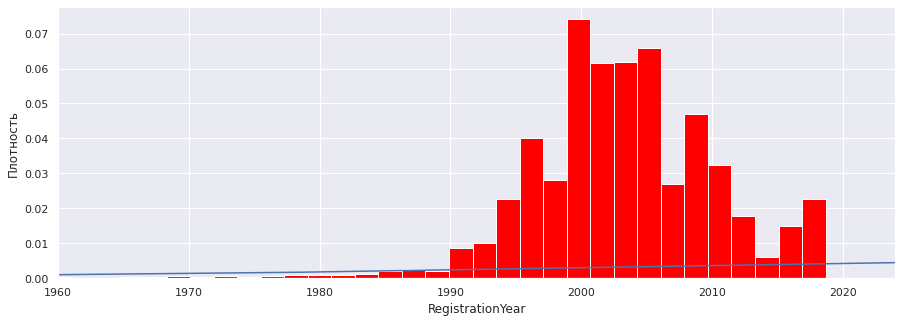

In [19]:
# Более детально посмотрим на столбец RegistrationYear
plt.rcParams['figure.figsize'] = (15, 5)
ax = sns.distplot(a=data['RegistrationYear'], label=data['RegistrationYear'], hist=True, kde=True, rug=False, 
                  bins=5000, hist_kws={"color":"red", "alpha":1})
plt.xlim(1960, 2024)
ax.set_ylabel('Плотность')
sns.set(rc={'figure.figsize':(20,5)})
plt.show();

<Axes: >

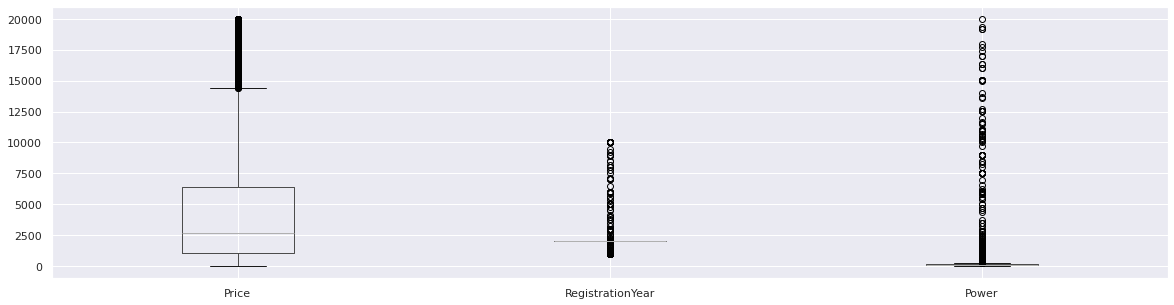

In [20]:
data.boxplot(column=['Price', 'RegistrationYear', 'Power'])

In [21]:
data.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN


Колличество пропусков в VehicleType около 10 процентов, данных слишком много чтобы просто от них избавится, если заменить на среднюю это тоже может сказаться на точности предсказания. Если брать в расчет что в дальнейшем пользователи при оценке автомобиля могут так же не вводить тип кузова, то стоит заменить пропущенные значения на unknown

In [22]:
# Признак имеет значение unknown, пропуски можно заполнить им
data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Gearbox'].fillna('unknown', inplace=True)
data['Model'].fillna('unknown', inplace=True)
data['Repaired'].fillna('unknown', inplace=True)

# Признак имеет значение other, пропуски можно заполнить им
data['FuelType'].fillna('other', inplace=True)

При очистке данных от пропусков стоял выбор между полным удалением объектов с пропусками(из за того что мы не могли на основе других параметров объекта достоверно восстановить упущенную информацию) и заполнение их наиболее часто встречающимся значением(так как это все категорийные признаки). По моим подсчетам, удаление объектов с пропусками привело бы к потере более 20% данных, что критично

In [23]:
# Удалим все 0 из целевого признака:
data = data.query('Price > 0')

In [24]:
# Посмотрим уникальные значения столбца RegistrationYear
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1959, 1956,
       3200, 1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957,
       1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 6500, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934,
       1938, 1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931,
       4500, 1602, 7800, 1947, 1927, 7100, 8200, 1946])

In [25]:
print("Колличество объявлений с некорректной годом:", len(data.loc[(data['RegistrationYear'] > 2016) | 
                                                                   (data['RegistrationYear'] < 1901)]))

Колличество объявлений с некорректной годом: 13832


Официально регистрация авто началась в 1901 году (это будет наше ограничение снизу), а выгрузка из базы нашего датасета была в 2016 году (это наше ограничение сверху). Применим эти ограничения, чтобы избавиться от явных выбросов в данных.

In [26]:
data = data.query('RegistrationYear > 1901 & RegistrationYear < 2016')
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2007,
       2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006, 1999,
       2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982, 1976,
       1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980, 1970, 1965, 1945,
       1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1966, 1975,
       1963, 1964, 1960, 1958, 1967, 1959, 1956, 1941, 1962, 1929, 1957,
       1940, 1949, 1937, 1951, 1953, 1954, 1950, 1948, 1952, 1932, 1942,
       1935, 1933, 1936, 1923, 1930, 1944, 1943, 1934, 1938, 1928, 1931,
       1947, 1927, 1946])

In [27]:
# Посмотрим уникальные значения столбца Power
data['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,   136,   160,   231,    50,   118,
         193,    99,    60,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,   143,   286,   232,   150,   156,
          80,    82,    90,   155,    54,   185,    87,   180,    86,
          84,   224,   235,   200,   178,   265,    77,   110,   144,
         120,   116,   184,   126,   204,    88,   194,    64,   305,
         197,   179,   250,    45,   313,    41,   165,    98,   130,
         114,   211,    56,   201,   213,    58,   107,   174,   100,
         220,    73,   192,    68,    66,   299,    74,    52,   147,
          71,    97,    65,   239,   203,     5,   300,   103,    85,
         258,   320,    63,    81,   148,    44,    83,   145,    55,
         280,   260,   104,   188,   333,   186,   117,   141,   132,
         234,   158,    39,    92,    51,   135,   230,    53,   209,
          43,   146,

In [28]:
print("Колличество объявлений с некорректной мощностью:",len(data.loc[(data['Power'] > 1600) | (data['Power'] <= 2)]))

Колличество объявлений с некорректной мощностью: 30468


In [29]:
# Так как легковых машин/автобусов с мощьностью 1 и более 1600 не существует, то избавимся от таких записей
data = data.query('Power > 1 & Power < 1600')
data['Power'].unique()

array([ 190,  163,   75,   69,  102,  109,  125,  101,  105,  140,  115,
        131,  136,  160,  231,   50,  118,  193,   99,   60,  113,  218,
        122,  129,   70,  306,   95,   61,  177,  170,  143,  286,  232,
        150,  156,   80,   82,   90,  155,   54,  185,   87,  180,   86,
         84,  224,  235,  200,  178,  265,   77,  110,  144,  120,  116,
        184,  126,  204,   88,  194,   64,  305,  197,  179,  250,   45,
        313,   41,  165,   98,  130,  114,  211,   56,  201,  213,   58,
        107,  174,  100,  220,   73,  192,   68,   66,  299,   74,   52,
        147,   71,   97,   65,  239,  203,    5,  300,  103,   85,  258,
        320,   63,   81,  148,   44,   83,  145,   55,  280,  260,  104,
        188,  333,  186,  117,  141,  132,  234,  158,   39,   92,   51,
        135,  230,   53,  209,   43,  146,   67,  106,  166,  276,  344,
         72,  249,  237,  245,  111,  326,  279,   23,  138,  310,  175,
         96,  226,   26,   37,  301,  334,  128,  1

In [30]:
data['Power'] = data['Power'].astype('int64')

In [31]:
# Приведем наименования столбцов к хорошему стилю после всей обработки данных
data = clean_columns(data)
print(data.head())

   price vehicle_type  registration_year gearbox  power    model  kilometer  \
1  18300        coupe               2011  manual    190  unknown     125000   
2   9800          suv               2004    auto    163    grand     125000   
3   1500        small               2001  manual     75     golf     150000   
4   3600        small               2008  manual     69    fabia      90000   
5    650        sedan               1995  manual    102      3er     150000   

  fuel_type       brand repaired  
1  gasoline        audi      yes  
2  gasoline        jeep  unknown  
3    petrol  volkswagen       no  
4  gasoline       skoda       no  
5    petrol         bmw      yes  


In [32]:
# Преобразуем столбцы с категориальными признаки в тип данных category
categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for col in categorical:
    data[col] = data[col].astype('category')

In [33]:
print(data.shape)

(290330, 10)


Так как мы удалили часть признаков, у нас могут появиться новые явные дубликаты: чем меньше признаков остаётся, тем выше шанс, что значения остальных признаков будут пересекаться. При этом ценности для модели такие наблюдения уже не принесут, поэтому стоит проверить дубликаты также в финальной версии таблицы.

In [34]:
data[data.duplicated(keep=False)].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no
20,10400,coupe,2009,manual,160,scirocco,100000,petrol,volkswagen,no
27,6900,sedan,2008,manual,99,civic,60000,petrol,honda,no
46,7999,sedan,2007,manual,177,1er,150000,gasoline,bmw,no


In [35]:
data = data.drop_duplicates(keep='first')

In [36]:
data = data.dropna()

In [37]:
print(data.shape)

(251564, 10)


**Итог**

- Была изучена таблица данных
- Выведены и обработаны аномальные и пропущенные значения
- Отобраны небходимые столбцы для обучения модели, от остальных избавились, так как они никак не влияют на цену
- Пробег и цену не трогали, так как здесь значения могут быть самыми разными
- Категориальные признаки были приведены к типу данных category
- Были изменены имена столбцов на snake_case
- Данные были очищены от выбросов и дубликатов. Суммарно было удалено примерно 100000 объектов, что составляет около 30%. Это достаточно большой процент, поэтому в случае низких результатов модели имеет смысл изменить эту цифру

## Обучение моделей

Применим прямое кодирование

In [38]:
# Выведем признаки для обучения моделей DT, CBR и LGBM
features = data.drop(['price'], axis = 1)
target = data['price']

Энкодер (как и Скалер) нельзя обучать на полных данных.\
Для вычисления трансформаций они используют информацию о всех поданных в них данных и обучение на полных данных приводит к утечке из обучающей выборки во все остальные. Тестовые и валидационные выборки можно только трансформировать, предобработчиками обученными на train.

In [39]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size=0.2, random_state=12345)

In [40]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [41]:
numeric_cols = ['power', 'kilometer', 'registration_year']
categ_transformer = ColumnTransformer(
    [('cat_transform', OneHotEncoder(), categorical)],
    remainder='passthrough')

# Сначала натренируем трансформер на выборке train
categ_transformer.fit(features_train_ohe)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_transform', OneHotEncoder(),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired'])])

In [42]:
features_train_ohe = pd.DataFrame.sparse.from_spmatrix(
    categ_transformer.transform(features_train_ohe),
    columns=categ_transformer.get_feature_names_out())

features_train_ohe.head()

,cat_transform__vehicle_type_bus,cat_transform__vehicle_type_convertible,cat_transform__vehicle_type_coupe,cat_transform__vehicle_type_other,cat_transform__vehicle_type_sedan,cat_transform__vehicle_type_small,cat_transform__vehicle_type_suv,cat_transform__vehicle_type_unknown,cat_transform__vehicle_type_wagon,cat_transform__gearbox_auto,cat_transform__gearbox_manual,cat_transform__gearbox_unknown,cat_transform__model_100,cat_transform__model_145,cat_transform__model_147,cat_transform__model_156,cat_transform__model_159,cat_transform__model_1_reihe,cat_transform__model_1er,cat_transform__model_200,cat_transform__model_2_reihe,cat_transform__model_300c,cat_transform__model_3_reihe,cat_transform__model_3er,cat_transform__model_4_reihe,cat_transform__model_500,cat_transform__model_5_reihe,cat_transform__model_5er,cat_transform__model_601,cat_transform__model_6_reihe,cat_transform__model_6er,cat_transform__model_7er,cat_transform__model_80,cat_transform__model_850,cat_transform__model_90,cat_transform__model_900,cat_transform__model_9000,cat_transform__model_911,cat_transform__model_a1,cat_transform__model_a2,cat_transform__model_a3,cat_transform__model_a4,cat_transform__model_a5,cat_transform__model_a6,cat_transform__model_a8,cat_transform__model_a_klasse,cat_transform__model_accord,cat_transform__model_agila,cat_transform__model_alhambra,cat_transform__model_almera,cat_transform__model_altea,cat_transform__model_amarok,cat_transform__model_antara,cat_transform__model_arosa,cat_transform__model_astra,cat_transform__model_auris,cat_transform__model_avensis,cat_transform__model_aveo,cat_transform__model_aygo,cat_transform__model_b_klasse,cat_transform__model_b_max,cat_transform__model_beetle,cat_transform__model_berlingo,cat_transform__model_bora,cat_transform__model_boxster,cat_transform__model_bravo,cat_transform__model_c1,cat_transform__model_c2,cat_transform__model_c3,cat_transform__model_c4,cat_transform__model_c5,cat_transform__model_c_klasse,cat_transform__model_c_max,cat_transform__model_c_reihe,cat_transform__model_caddy,cat_transform__model_calibra,cat_transform__model_captiva,cat_transform__model_carisma,cat_transform__model_carnival,cat_transform__model_cayenne,cat_transform__model_cc,cat_transform__model_ceed,cat_transform__model_charade,cat_transform__model_cherokee,cat_transform__model_citigo,cat_transform__model_civic,cat_transform__model_cl,cat_transform__model_clio,cat_transform__model_clk,cat_transform__model_clubman,cat_transform__model_colt,cat_transform__model_combo,cat_transform__model_cooper,cat_transform__model_cordoba,cat_transform__model_corolla,cat_transform__model_corsa,cat_transform__model_cr_reihe,cat_transform__model_croma,cat_transform__model_crossfire,cat_transform__model_cuore,cat_transform__model_cx_reihe,cat_transform__model_defender,cat_transform__model_delta,cat_transform__model_discovery,cat_transform__model_doblo,cat_transform__model_ducato,cat_transform__model_duster,cat_transform__model_e_klasse,cat_transform__model_elefantino,cat_transform__model_eos,cat_transform__model_escort,cat_transform__model_espace,cat_transform__model_exeo,cat_transform__model_fabia,cat_transform__model_fiesta,cat_transform__model_focus,cat_transform__model_forester,cat_transform__model_forfour,cat_transform__model_fortwo,cat_transform__model_fox,cat_transform__model_freelander,cat_transform__model_fusion,cat_transform__model_g_klasse,cat_transform__model_galant,cat_transform__model_galaxy,cat_transform__model_getz,cat_transform__model_gl,cat_transform__model_glk,cat_transform__model_golf,cat_transform__model_grand,cat_transform__model_i3,cat_transform__model_i_reihe,cat_transform__model_ibiza,cat_transform__model_impreza,cat_transform__model_insignia,cat_transform__model_jazz,cat_transform__model_jetta,cat_transform__model_jimny,cat_transform__model_juke,cat_transform__model_justy,cat_transform__model_ka,cat_transform__model_kadett,cat_transform__model_kaefer,cat_transform__model_kalina,cat_transform__model_kalos,

In [43]:
features_test_ohe = pd.DataFrame.sparse.from_spmatrix(
    categ_transformer.transform(features_test_ohe),
    columns=categ_transformer.get_feature_names_out())

features_test_ohe.head()

,cat_transform__vehicle_type_bus,cat_transform__vehicle_type_convertible,cat_transform__vehicle_type_coupe,cat_transform__vehicle_type_other,cat_transform__vehicle_type_sedan,cat_transform__vehicle_type_small,cat_transform__vehicle_type_suv,cat_transform__vehicle_type_unknown,cat_transform__vehicle_type_wagon,cat_transform__gearbox_auto,cat_transform__gearbox_manual,cat_transform__gearbox_unknown,cat_transform__model_100,cat_transform__model_145,cat_transform__model_147,cat_transform__model_156,cat_transform__model_159,cat_transform__model_1_reihe,cat_transform__model_1er,cat_transform__model_200,cat_transform__model_2_reihe,cat_transform__model_300c,cat_transform__model_3_reihe,cat_transform__model_3er,cat_transform__model_4_reihe,cat_transform__model_500,cat_transform__model_5_reihe,cat_transform__model_5er,cat_transform__model_601,cat_transform__model_6_reihe,cat_transform__model_6er,cat_transform__model_7er,cat_transform__model_80,cat_transform__model_850,cat_transform__model_90,cat_transform__model_900,cat_transform__model_9000,cat_transform__model_911,cat_transform__model_a1,cat_transform__model_a2,cat_transform__model_a3,cat_transform__model_a4,cat_transform__model_a5,cat_transform__model_a6,cat_transform__model_a8,cat_transform__model_a_klasse,cat_transform__model_accord,cat_transform__model_agila,cat_transform__model_alhambra,cat_transform__model_almera,cat_transform__model_altea,cat_transform__model_amarok,cat_transform__model_antara,cat_transform__model_arosa,cat_transform__model_astra,cat_transform__model_auris,cat_transform__model_avensis,cat_transform__model_aveo,cat_transform__model_aygo,cat_transform__model_b_klasse,cat_transform__model_b_max,cat_transform__model_beetle,cat_transform__model_berlingo,cat_transform__model_bora,cat_transform__model_boxster,cat_transform__model_bravo,cat_transform__model_c1,cat_transform__model_c2,cat_transform__model_c3,cat_transform__model_c4,cat_transform__model_c5,cat_transform__model_c_klasse,cat_transform__model_c_max,cat_transform__model_c_reihe,cat_transform__model_caddy,cat_transform__model_calibra,cat_transform__model_captiva,cat_transform__model_carisma,cat_transform__model_carnival,cat_transform__model_cayenne,cat_transform__model_cc,cat_transform__model_ceed,cat_transform__model_charade,cat_transform__model_cherokee,cat_transform__model_citigo,cat_transform__model_civic,cat_transform__model_cl,cat_transform__model_clio,cat_transform__model_clk,cat_transform__model_clubman,cat_transform__model_colt,cat_transform__model_combo,cat_transform__model_cooper,cat_transform__model_cordoba,cat_transform__model_corolla,cat_transform__model_corsa,cat_transform__model_cr_reihe,cat_transform__model_croma,cat_transform__model_crossfire,cat_transform__model_cuore,cat_transform__model_cx_reihe,cat_transform__model_defender,cat_transform__model_delta,cat_transform__model_discovery,cat_transform__model_doblo,cat_transform__model_ducato,cat_transform__model_duster,cat_transform__model_e_klasse,cat_transform__model_elefantino,cat_transform__model_eos,cat_transform__model_escort,cat_transform__model_espace,cat_transform__model_exeo,cat_transform__model_fabia,cat_transform__model_fiesta,cat_transform__model_focus,cat_transform__model_forester,cat_transform__model_forfour,cat_transform__model_fortwo,cat_transform__model_fox,cat_transform__model_freelander,cat_transform__model_fusion,cat_transform__model_g_klasse,cat_transform__model_galant,cat_transform__model_galaxy,cat_transform__model_getz,cat_transform__model_gl,cat_transform__model_glk,cat_transform__model_golf,cat_transform__model_grand,cat_transform__model_i3,cat_transform__model_i_reihe,cat_transform__model_ibiza,cat_transform__model_impreza,cat_transform__model_insignia,cat_transform__model_jazz,cat_transform__model_jetta,cat_transform__model_jimny,cat_transform__model_juke,cat_transform__model_justy,cat_transform__model_ka,cat_transform__model_kadett,cat_transform__model_kaefer,cat_transform__model_kalina,cat_transform__model_kalos,

In [44]:
features_train_ordinal = features_train.copy()
features_test_ordinal = features_test.copy()

In [45]:
numeric_cols = ['power', 'kilometer', 'registration_year']
categ_transformer = ColumnTransformer(
    [('cat_transform', OrdinalEncoder(), categorical)],
    remainder='passthrough')

# Сначала натренируем трансформер на выборке train
categ_transformer.fit(features_train_ordinal)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_transform', OrdinalEncoder(),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired'])])

In [46]:
features_train_ordinal = pd.DataFrame(
    categ_transformer.transform(features_train_ordinal),
    columns=categ_transformer.get_feature_names_out())

features_train_ordinal.head()

,cat_transform__vehicle_type,cat_transform__gearbox,cat_transform__model,cat_transform__fuel_type,cat_transform__brand,cat_transform__repaired,remainder__registration_year,remainder__power,remainder__kilometer
0,8.0,0.0,95.0,6.0,20.0,0.0,1996.0,136.0,150000.0
1,4.0,1.0,103.0,6.0,10.0,2.0,1998.0,116.0,150000.0
2,7.0,1.0,116.0,6.0,38.0,1.0,2000.0,125.0,150000.0
3,4.0,1.0,28.0,2.0,1.0,1.0,2004.0,131.0,150000.0
4,8.0,0.0,15.0,6.0,2.0,0.0,2000.0,170.0,150000.0


In [47]:
features_test_ordinal = pd.DataFrame(
    categ_transformer.transform(features_test_ordinal),
    columns=categ_transformer.get_feature_names_out())

features_test_ordinal.head()

,cat_transform__vehicle_type,cat_transform__gearbox,cat_transform__model,cat_transform__fuel_type,cat_transform__brand,cat_transform__repaired,remainder__registration_year,remainder__power,remainder__kilometer
0,6.0,0.0,241.0,6.0,2.0,0.0,2002.0,286.0,150000.0
1,1.0,1.0,42.0,6.0,24.0,2.0,1996.0,75.0,150000.0
2,8.0,0.0,11.0,2.0,2.0,0.0,2003.0,150.0,150000.0
3,8.0,1.0,42.0,2.0,24.0,2.0,2001.0,74.0,150000.0
4,4.0,1.0,227.0,6.0,30.0,1.0,1997.0,75.0,150000.0


Напишем функцию сбора данных о работе моделях, для последующего анализа:

In [48]:
def model_analysis_ohe(model, parameters, features_train, target_train):
    print(model)
    print('Parameter search started')
    grid = GridSearchCV(model, param_grid=parameters, cv=6, n_jobs=-1,
                        scoring = 'neg_root_mean_squared_error', error_score='raise')
    start_time = time.time()
    print('Training has started')
    grid.fit(features_train, target_train)
    first_time = time.time() - start_time
    start_time = time.time()
    print('Prediction started')
    predict = grid.predict(features_test_ohe)
    second_time = time.time() - start_time
    rmse = grid.best_score_  # Берём оценку кросс-валидацией. Сравнивать модели на тестовых данных нельзя!
    second_time = time.time() - start_time
    stat_data = [grid.refit_time_, second_time, rmse]
    return stat_data, grid

In [49]:
def model_analysis_ordinal(model, parameters, features_train, target_train):
    print(model)
    print('Parameter search started')
    grid = GridSearchCV(model, param_grid=parameters, cv=6, n_jobs=1,
                        scoring = 'neg_root_mean_squared_error', error_score='raise')
    start_time = time.time()
    print('Training has started')
    grid.fit(features_train, target_train)
    first_time = time.time() - start_time
    start_time = time.time()
    print('Prediction started')
    predict = grid.predict(features_test_ordinal)
    second_time = time.time() - start_time
    rmse = grid.best_score_  # Берём оценку кросс-валидацией. Сравнивать модели на тестовых данных нельзя!
    stat_data = [grid.refit_time_, second_time, rmse]
    return stat_data, grid

### Ridge

In [50]:
ridge_model = Ridge(random_state=12345)

In [51]:
param_grid_ridge = {'alpha': np.arange(0.1, 0.21, 0.1),}

In [52]:
ridge_stat_ohe, ridge_grid_ohe = model_analysis_ohe(ridge_model, param_grid_ridge,
                                         features_train_ohe, target_train)
ridge_stat_ohe

Ridge(random_state=12345)
Parameter search started
Training has started
Prediction started


[2.7018651962280273, 0.3040733337402344, -2703.315154275095]

In [53]:
ridge_grid_ohe

GridSearchCV(cv=6, error_score='raise', estimator=Ridge(random_state=12345),
             n_jobs=-1, param_grid={'alpha': array([0.1, 0.2])},
             scoring='neg_root_mean_squared_error')

### CatBoost

In [54]:
catboost_model = CatBoostRegressor(random_state=12345, silent=True)

In [55]:
params_catboost = {
    'learning_rate': [0.1],
    'iterations': [8,35,95],
    'max_depth': [11,16]
}

In [56]:
features_train_ordinal.iteritems = features_train_ordinal.items
catboost_stat_ordinal, catboost_grid_ordinal = model_analysis_ordinal(catboost_model, params_catboost,
                                              features_train_ordinal, target_train)
catboost_stat_ordinal

Parameter search started
Training has started
Prediction started


[116.92404985427856, 0.051593780517578125, -1639.6371821318173]

In [57]:
catboost_grid_ordinal

GridSearchCV(cv=6, error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc618235c70>,
             n_jobs=1,
             param_grid={'iterations': [8, 35, 95], 'learning_rate': [0.1],
                         'max_depth': [11, 16]},
             scoring='neg_root_mean_squared_error')

### LightGBM

In [58]:
lgbm_model = LGBMRegressor(random_state=12345, num_threads = 5)

In [59]:
param_lgbm = {
    'n_estimators': [25,80,220],
    'max_depth': [12, 28, 45],
    'num_leaves': [8,15,35],
    'learning_rate': [0.12]
}

In [60]:
%%capture
lgbm_stat_ordinal, lgbm_grid_ordinal = model_analysis_ordinal(lgbm_model, param_lgbm,
                                      features_train_ordinal, target_train)
lgbm_stat_ordinal

In [61]:
lgbm_grid_ordinal

GridSearchCV(cv=6, error_score='raise',
             estimator=LGBMRegressor(num_threads=5, random_state=12345),
             n_jobs=1,
             param_grid={'learning_rate': [0.12], 'max_depth': [12, 28, 45],
                         'n_estimators': [25, 80, 220],
                         'num_leaves': [8, 15, 35]},
             scoring='neg_root_mean_squared_error')

## Анализ моделей

In [62]:
analysis_data= pd.DataFrame([ridge_stat_ohe, # catboost_stat_ohe, lgbm_stat_ohe, ridge_stat_ordinal,
                             catboost_stat_ordinal, lgbm_stat_ordinal], 
             columns=['Время обучения', 'Время предсказания', 'RMSE'], 
                      index=['Ridge_ohe', #'CatBoost_ohe', 'LightGBM_ohe', 'Ridge_ordinal', 
                             'CatBoost_ordinal', 'LightGBM_ordinal'])
analysis_data

,Время обучения,Время предсказания,RMSE
Ridge_ohe,2.701865,0.304073,-2703.315154
CatBoost_ordinal,116.924050,0.051594,-1639.637182
LightGBM_ordinal,4.985767,0.716524,-1622.154421


Основываясь на полученных результатах, можно сделать вывод, что:

- Самое маленькое RMSE у LightGBM_ordinal, а самое большое у Ridge_ohe
- Самое маленькое время предсказания у CatBoost_ordinal, а самое большое у LightGBM_ordinal                  
- Самое маленькое время обучения у Ridge_ohe, а самое большое у CatBoost_ordinal                 

Чтобы определить какая из моделей нам подойдет больше, нужно выбрать что для нас важнее - время обучения/предсказания или ошибка. Важно, чтобы время предсказания было как можно меньше - обучаем модель мы только один раз, но предсказывать она может до бесконечности. С учетом этого лучшей моделью можно считать CatBoost_ordinal. Если же заказчик определит критерии важности иначе, то и выбранная модель изменится.

In [63]:
predict = lgbm_grid_ordinal.predict(features_test_ordinal)
mean_squared_error(target_test, predict) ** 0.5

1631.1095559885775

## Общий Вывод

В результате выполнения проекта решена задача и достигнута цель - построена модель, чтобы узнать рыночную стоимость своего автомобиля. 

В ходе работы было выполнено:

- Была изучена таблица данных
- Выведены и обработаны аномальные и пропущенные значения
- Отобраны небходимые столбцы для обучения модели, от остальных избавились, так как они никак не влияют на цену
- Пробег и цену не трогали, так как здесь значения могут быть самыми разными
- Категориальные признаки были приведены к типу данных category
- Были изменены имена столбцов на snake_case
- Данные были очищены от выбросов, суммарно было удалено примерно 100000 объектов, что составляет около 30%. Это достаточно большой процент, поэтому в случае низких результатов модели имеет смысл изменить эту цифру
- Были построены модели
- Выполнено сравнение моделей с использованием различных наборов гиперпараметров
- Выбрана лучшая модель по результатам метрики RMSE, скорости и времени обучения

С учетом того, что время предсказания меньше всего у CatBoost_ordinal, то эту модель и считаем лучшей. Если же заказчик определит критерии важности иначе, то и выбранная модель изменится. Например, у CatBoost_ordinal худшее Время обучения и по этому показателю данную модель точно не стоит выбирать.